In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_io as tfio
import json
import matplotlib.pyplot as plt


In [2]:
data_dir = '../input/correct-directory-extraction/cough_outputs'
samples = os.listdir(data_dir)
samples[:5], len(samples[0]), len(samples[1]), len(samples)

(['0dfJArS4xbNhay72hpzOvlHkpIj2',
  'uAEOVPr487bFnks4dvytsxJQZP02',
  'Hge7rEPBdLcy4ckCtvUFfl4p0Ne2',
  'zGjGkKCAjkdA9S3aSreocxkWf0C2',
  'RmWwhKI8kjPi5qN9H740rfm0jHA2'],
 28,
 28,
 897)

In [3]:
samples = [sample for sample in samples if len(sample) == 28]
len(samples)

887

In [4]:
ind_paths = []
for i in samples:
    ind_paths.append(os.path.join(data_dir, i))    


In [5]:
ind_cough_paths = []
for i in ind_paths:
    ind_cough_paths.append(os.path.join(i, 'cough-heavy.wav'))
    

In [6]:
ind_labels = []

for i in ind_paths:
    with open(os.path.join(i,'metadata.json'), 'r') as file:
        metadata = json.load(file)
        covid_status = metadata['covid_status']
        if covid_status.startswith('positive'):
            ind_labels.append(1)
        else:
            ind_labels.append(0)
        

In [7]:
sum(ind_labels), len(samples)

(414, 887)

In [8]:
ind_cough_paths[:10], ind_labels[:10]

(['../input/correct-directory-extraction/cough_outputs/0dfJArS4xbNhay72hpzOvlHkpIj2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/uAEOVPr487bFnks4dvytsxJQZP02/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/Hge7rEPBdLcy4ckCtvUFfl4p0Ne2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/zGjGkKCAjkdA9S3aSreocxkWf0C2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/RmWwhKI8kjPi5qN9H740rfm0jHA2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/ZPup16g7iWhU8qGhXNlgpgiN7ow2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/gFmySpqfQ7YrYqMrmrMPO7AzmBm1/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/PoxsEOv7MmbHaY4qT3wNcK8GWrV2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/RebRt0aSpjOeqnezG7i5XQn03Ql2/cough-heavy.wav',
  '../input/correct-directory-extraction/cough_outputs/OUUxmNJuz3Wp0zoDNFdsiEtBstb

In [9]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [10]:
wave = load_wav_16k_mono(ind_cough_paths[1])
nwave = load_wav_16k_mono(ind_cough_paths[5])

2022-10-27 14:33:33.918917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:33:33.919895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:33:34.099332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:33:34.100343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:33:34.101180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

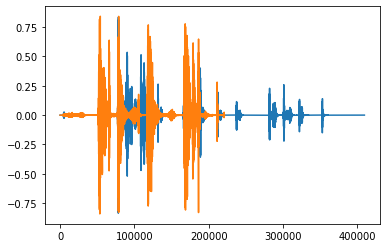

In [11]:
plt.plot(wave)
plt.plot(nwave)

In [12]:
data = tf.data.Dataset.from_tensor_slices((ind_cough_paths, ind_labels))
len(data)

887

In [13]:
# for element in sample_data.as_numpy_iterator():
#     print(element)

(array([ 29.,  74., 212., 236., 180.,  86.,  38.,  15.,   7.,   0.,   4.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   2.]),
 array([      0. ,   72089.6,  144179.2,  216268.8,  288358.4,  360448. ,
         432537.6,  504627.2,  576716.8,  648806.4,  720896. ,  792985.6,
         865075.2,  937164.8, 1009254.4, 1081344. , 1153433.6, 1225523.2,
        1297612.8, 1369702.4, 1441792. ]),
 <BarContainer object of 20 artists>)

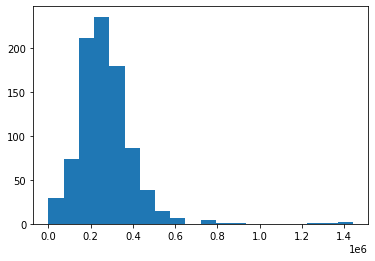

In [14]:
lengths = []
for file in ind_cough_paths:
    tensor_wave = load_wav_16k_mono(file)
    lengths.append(len(tensor_wave))
plt.hist(lengths, bins=20)

In [15]:
np.quantile(lengths, .85)

373145.6000000001

In [16]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:375000]
    zero_padding = tf.zeros([375000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=2048, frame_step=512, fft_length=2048)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    spectogram = tf.image.resize(spectogram, [380,380])
    spectogram = tf.image.grayscale_to_rgb(spectogram)
    return spectogram, label

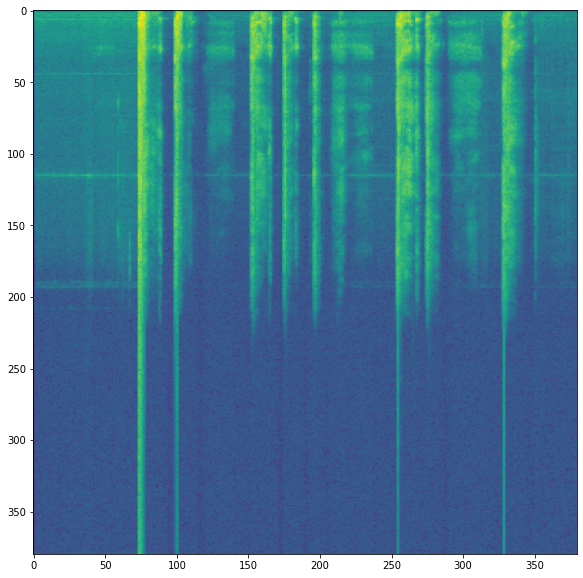

In [17]:
filepath, label = data.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)
spectogram.shape

plt.figure(figsize=(10,10))
plt.imshow(np.log(tf.transpose(spectogram)[0]))
plt.show()

In [18]:
spectogram.shape

TensorShape([380, 380, 3])

In [19]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [20]:
len(data)

56

In [21]:
train = data.take(40)
test = data.skip(40)
len(train), len(test)

(40, 16)

In [22]:
# samples, labels = train.as_numpy_iterator().next()
# samples.shape, labels

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalMaxPool2D, MaxPool2D
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

In [24]:
inputs = tf.keras.Input(shape=(380, 380, 3), name='input_audio')
base_model = tf.keras.applications.EfficientNetB4(input_tensor=inputs,
                                include_top=False, 
                                weights='imagenet',
                                drop_connect_rate=0.4,
                                                 )

x = L.GlobalAveragePooling2D()(base_model.output)
x = L.Dropout(.5)(x)
output = L.Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=inputs, outputs=output)

71696384/71686520 [==============================] - 0s 0us/step


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss='BinaryCrossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [26]:
history = model.fit(train, epochs=40, validation_data=test)

Epoch 1/40


2022-10-27 14:34:08.892448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-27 14:34:23.656752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 89 of 1000
2022-10-27 14:34:33.632572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 189 of 1000
2022-10-27 14:34:43.624673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 289 of 1000
2022-10-27 14:34:53.678748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 381 of 1000
2022-10-27 14:35:03.777636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 481 of 1000
2022-10-27 14:35:13.772411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shu

40/40 [==============================] - 170s 1s/step - loss: 0.6919 - accuracy: 0.5641 - recall: 0.4515 - precision: 0.5400 - val_loss: 0.6890 - val_accuracy: 0.5466 - val_recall: 0.5000 - val_precision: 0.5179


2022-10-27 14:36:47.246823: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-27 14:36:47.246930: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-27 14:36:47.312422: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-27 14:36:47.312519: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

Epoch 2/40
40/40 [==============================] - 48s 1s/step - loss: 0.6404 - accuracy: 0.6062 - recall: 0.6041 - precision: 0.5655 - val_loss: 0.7228 - val_accuracy: 0.5304 - val_recall: 0.0169 - val_precision: 1.0000
Epoch 3/40
40/40 [==============================] - 49s 1s/step - loss: 0.5875 - accuracy: 0.7063 - recall: 0.6623 - precision: 0.7038 - val_loss: 0.6885 - val_accuracy: 0.5709 - val_recall: 0.2437 - val_precision: 0.6444
Epoch 4/40
40/40 [==============================] - 48s 1s/step - loss: 0.5012 - accuracy: 0.7609 - recall: 0.7285 - precision: 0.7560 - val_loss: 0.6505 - val_accuracy: 0.6113 - val_recall: 0.4758 - val_precision: 0.6556
Epoch 5/40
40/40 [==============================] - 49s 1s/step - loss: 0.4224 - accuracy: 0.8047 - recall: 0.7509 - precision: 0.8088 - val_loss: 0.6995 - val_accuracy: 0.6397 - val_recall: 0.6018 - val_precision: 0.6071
Epoch 6/40
40/40 [==============================] - 49s 1s/step - loss: 0.3874 - accuracy: 0.8453 - recall: 0.82

In [27]:
model.evaluate(test)

16/16 [==============================] - 4s 205ms/step - loss: 0.2670 - accuracy: 0.8704 - recall: 0.7328 - precision: 0.9884


[0.26699209213256836,
 0.8704453706741333,
 0.732758641242981,
 0.9883720874786377]

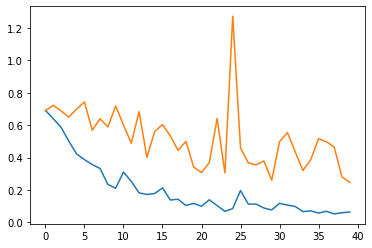

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

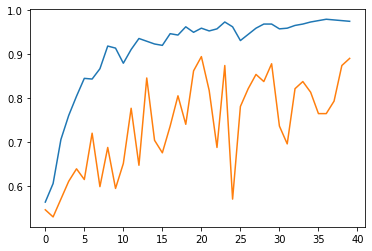

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

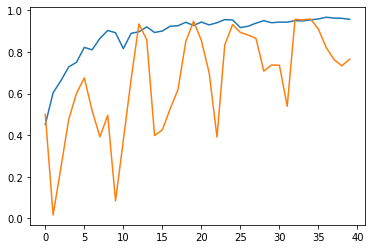

In [30]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

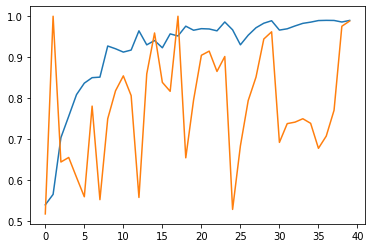

In [31]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])